### For a cleaned up, stream-lined version of De-duplication code, look under "cleaning" file for "2020-07-14_deduplication_no_eda"
#### This notebook is a combination of Exploratory Data Analysis, Data Profiling and De-duplication. Because of this mish-mash, some code may be out of order for proper functioning. There is some documentation through out the code, but not everywhere.

In [255]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

#from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import pairwise_distances

#from gensim.models.coherencemodel import CoherenceModel

#import TextCleaning_update

In [256]:
# pull in old 2018 raw abstracts
old = pd.read_csv('../../data/original/raw_abstracts.csv',engine='python')

# remove null abstracts and duplicates
#olddf = TextCleaning.remove_nulls(raw_df, "ABSTRACT")
#olddf = TextCleaning.remove_duplicates(df)

old.reset_index(inplace = True)
old.rename(columns={'index':'original index'}, inplace=True)

In [257]:
#import new data with 2019 added

raw = pd.read_csv('../../data/original/working_federal_reporter_2020.csv',engine='python')

In [258]:
#df = new
#df = TextCleaning.remove_nulls(new, "ABSTRACT")
#df = TextCleaning.remove_duplicates(df)

raw.reset_index(inplace = True)
raw.rename(columns={'index':'original index'}, inplace=True)

In [321]:
#create working df to make changes but keep raw file as is
rnd = raw

## Assess difference between two 'FY' columns

In [322]:
disagree_years = raw[raw['FY.x'] != raw['FY.y']][['FY.x','FY.y']]
disagree_years.isnull().sum()

FY.x     0
FY.y    19
dtype: int64

In [323]:
#Fill NAs in FY.x column with values from FY.y
rnd['FY.x'] = rnd['FY.x'].fillna(rnd['FY.y'])

In [324]:
#recheck where FY columns are mismatched
rnd[rnd['FY.x'] != rnd['FY.y']][['FY.x','FY.y']].isnull().sum()

FY.x     0
FY.y    19
dtype: int64

In [325]:
#rnd[rnd['FY.x'] != rnd['FY.y']][['FY.x','FY.y']]

,FY.x,FY.y
16282,2008.0,NaN
50636,2008.0,NaN
73128,2008.0,NaN
73784,2008.0,81405.0
73807,2008.0,329831.0
87421,2008.0,7073.0
126758,2009.0,NaN
154276,2009.0,NaN
187001,2009.0,320749.0
187618,2009.0,79171.0


In [326]:
#rename 'FY.x' as 'FY' to fit downstream code
rnd = rnd.rename(columns={'FY.x': 'FY'})

In [327]:
#drop FY.y columns
rnd = rnd.drop(['FY.y'], axis=1)

### Fill empty PROJECT_START/END_DATEs  with BUDGET END/START DATEs or FY

In [328]:
# For rows with missing Project Start Date, how many also have missing Budget Start Date
rnd[rnd.PROJECT_START_DATE.isnull()]['BUDGET_START_DATE'].isnull().sum()

82415

In [329]:
# For rows with missing Project Start Date, how many are NOT missing Budget Start Date
rnd[rnd.PROJECT_START_DATE.isnull()]['BUDGET_START_DATE'].notnull().sum()

72511

In [330]:
# Fill missing values in Project Start Date with Budget Start Date
rnd['PROJECT_START_DATE'] = rnd['PROJECT_START_DATE'].fillna(rnd['BUDGET_START_DATE'])

In [331]:
rnd[['PROJECT_START_DATE']].isnull().sum()

PROJECT_START_DATE    82415
dtype: int64

In [332]:
# For rows with missing Project END Date, how many also have missing Budget END Date
rnd[rnd.PROJECT_END_DATE.isnull()]['BUDGET_END_DATE'].isnull().sum()

81204

In [333]:
# For rows with missing Project END Date, how many are NOT missing Budget END Date
rnd[rnd.PROJECT_END_DATE.isnull()]['BUDGET_END_DATE'].notnull().sum()

65128

In [334]:
# Fill missing values in Project Start Date with Budget Start Date
rnd['PROJECT_END_DATE'] = rnd['PROJECT_END_DATE'].fillna(rnd['BUDGET_END_DATE'])

In [335]:
rnd[['PROJECT_END_DATE']].isnull().sum()

PROJECT_END_DATE    81204
dtype: int64

#### If START date still missing, fill with FY

In [336]:
rnd['PROJECT_START_DATE'] = rnd['PROJECT_START_DATE'].fillna(rnd['FY'])

In [337]:
rnd[['PROJECT_START_DATE']].isnull().sum()

PROJECT_START_DATE    0
dtype: int64

## Null ABSTRACT values

In [338]:
len(raw[raw.ABSTRACT.isnull()])

42380

In [339]:
len(rnd[rnd.ABSTRACT.isnull()])

42380

In [340]:
len(rnd[rnd.PROJECT_TITLE.isnull()])

0

In [341]:
# create df as dedup, dropping NAN abstracts
rnd = rnd[~rnd.ABSTRACT.isnull()]

In [342]:
len(rnd)

1113757

In [343]:
len(raw)

1156137

In [344]:
rnd[rnd.ABSTRACT == '']

,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,...,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS


In [345]:
# drop abstracts with values of "ABSTRACT NOT PROVIDED" and "No abstract provided "
rnd = rnd[rnd.ABSTRACT != 'ABSTRACT NOT PROVIDED']
rnd = rnd[rnd.ABSTRACT != 'No abstract provided']
len(rnd)

1112433

# DE-DUPLICATION

In [346]:
# check to make sure "original index" columns do not have different values
(rnd['original index'] != rnd['original index']).sum()

0

In [347]:
rnd = rnd.drop(['original index'], axis=1)

In [348]:
#each row has a unique Project ID
pid = rnd.PROJECT_ID.value_counts()> 1
pid.sum()

0

In [349]:
#Some PROJECT_NUMBERs are repeated
pnum = rnd.PROJECT_NUMBER.value_counts()> 1
pnum.sum()

3576

In [350]:
#There are no rows that are exactly the same.
rnd[rnd.duplicated(subset=None, keep='first')]

,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,...,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS


In [351]:
len(
    rnd[rnd.duplicated(subset=['ABSTRACT', 'FY', 'PROJECT_TITLE', 'DEPARTMENT', 'AGENCY', 'PROJECT_TERMS',
      'PROJECT_START_DATE', 'PROJECT_END_DATE', 'CONTACT_PI_PROJECT_LEADER', 
       'FY_TOTAL_COST', 'FY_TOTAL_COST_SUB_PROJECTS'], keep='first')]
)

3161

In [352]:
len(rnd[rnd.duplicated(subset=['PROJECT_NUMBER'], keep='last')]
   )

6454

In [388]:
duplicates = rnd[rnd.duplicated(subset=['ABSTRACT',  'PROJECT_TITLE', #'DEPARTMENT', 'AGENCY', #'PROJECT_TERMS','FY',
      'PROJECT_START_DATE', #'PROJECT_END_DATE', 
                            # 'ORGANIZATION_NAME',
                             #'CONTACT_PI_PROJECT_LEADER', 
      # 'FY_TOTAL_COST', #'FY_TOTAL_COST_SUB_PROJECTS'
                        ], keep= False)]

In [389]:
len(duplicates)

612336

In [355]:
#There are no rows without a Project Title
rnd.PROJECT_TITLE.isnull().sum()

0

In [356]:
#Sort df by END date
rnd = rnd.sort_values(['PROJECT_END_DATE'])

In [357]:
null_date = rnd[rnd.PROJECT_START_DATE.isnull()]

In [358]:
len(null_date)

0

In [359]:
null_date_dup = null_date[null_date.duplicated(subset=['ABSTRACT', 'PROJECT_TITLE'], keep=False)]

In [360]:
len(null_date_dup)

0

In [361]:
len(null_date_dup.ABSTRACT.value_counts())

0

In [362]:
# where Proj_START is NAN, but END date is not duplicated, fill start date with previous end date

In [363]:
len(null_date_dup[~null_date_dup.duplicated(subset=['PROJECT_END_DATE'], keep=False)])

0

Since there are only 8 rows that have duplicated Start Date, Abstract and Project Title, but END Date is NOT duplicated, it is not worth the time to figure out how to fill the Start Dates with END dates from other rows with same Abstract/Title.

In [364]:
#Remove rows that have the same Abstract/Title/Start Date
dedup = rnd[~rnd.duplicated(subset=['ABSTRACT',  'PROJECT_TITLE', #'DEPARTMENT', 'AGENCY', #'PROJECT_TERMS','FY',
      'PROJECT_START_DATE', #'PROJECT_END_DATE', 
                            # 'ORGANIZATION_NAME',
                             #'CONTACT_PI_PROJECT_LEADER', 
      # 'FY_TOTAL_COST', #'FY_TOTAL_COST_SUB_PROJECTS'
                        ], keep='last')]


In [365]:
len(dedup)

698600

### How many different organizations/PIs are there within each group of duplicate rows?

In [391]:
duplicates.ORGANIZATION_NAME.isnull().sum()

222

In [393]:
# Number of unique ABSTRACTS in data frame
len(rnd.ABSTRACT.value_counts())

578211

In [429]:
grouped = duplicates.groupby(['ABSTRACT', 'PROJECT_TITLE', 'PROJECT_START_DATE'])

In [430]:
#number of unique ABSTRACTS that have at least 1 duplicate
len(grouped)

198503

In [433]:
# count of how many abstracts have X number of unique organizations
grouped['ORGANIZATION_NAME'].nunique().value_counts()

1     177309
2      18132
3       2075
4        556
5        182
6         66
7         40
0         39
8         33
9         24
11         8
13         8
10         7
12         6
15         4
19         3
14         2
16         2
18         2
28         1
17         1
20         1
22         1
31         1
Name: ORGANIZATION_NAME, dtype: int64

In [434]:
# group whole df by abstract/title/start_date (exact matches)
all_grp = rnd.groupby(['ABSTRACT', 'PROJECT_TITLE', 'PROJECT_START_DATE'])

In [435]:
# for each unique ABSTRACT/TITLE/START_DATE in whole df, count unique organizations
unique_all = all_grp.agg({'ORGANIZATION_NAME' : 'nunique'}) 
unique_all = unique_all.rename(columns={'ORGANIZATION_NAME': 'ORG_COUNT'})

In [444]:
merged = rnd.merge(unique_all, left_on=['ABSTRACT', 'PROJECT_TITLE', 'PROJECT_START_DATE'], right_on=['ABSTRACT', 'PROJECT_TITLE', 'PROJECT_START_DATE'])

In [449]:
# for each unique ABSTRACT/TITLE/START_DATE in whole df, count unique PIs
unique_pi = all_grp.agg({'CONTACT_PI_PROJECT_LEADER' : 'nunique'}) 
unique_pi = unique_pi.rename(columns={'CONTACT_PI_PROJECT_LEADER': 'PI_COUNT'})
merged_pi = merged.merge(unique_pi, left_on=['ABSTRACT', 'PROJECT_TITLE', 'PROJECT_START_DATE'], right_on=['ABSTRACT', 'PROJECT_TITLE', 'PROJECT_START_DATE'])

#### Examine specific ABSTRACTS with duplicate rows

In [453]:
raw.ABSTRACT.value_counts()

ABSTRACT NOT PROVIDED                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [305]:
# Abstract w/ highest occurances in raw (2019) data
common_raw = raw[raw.ABSTRACT == "The Vaccine and Treatment Evaluation Units (VTEUs) are a consortium of individual contracts within academic centers and organizations that provide a ready resource for the design and conduct of clinical trials to evaluate promising vaccines and treatments for infectious disease. Investigations of novel product delivery systems and routes of delivery may also be conducted. In general, products will be evaluated in normal healthy populations; however, access to special populations is also available."]

In [306]:
len(common_raw)

258

In [307]:
# Abstract w/ highest occurances in de-duplicated and -NAN  2019 data
common_df = rnd[rnd.ABSTRACT == "The Vaccine and Treatment Evaluation Units (VTEUs) are a consortium of individual contracts within academic centers and organizations that provide a ready resource for the design and conduct of clinical trials to evaluate promising vaccines and treatments for infectious disease. Investigations of novel product delivery systems and routes of delivery may also be conducted. In general, products will be evaluated in normal healthy populations; however, access to special populations is also available."]

In [308]:
len(common_df)

258

In [309]:
# High Count Abstract in raw 2019 data
common_raw[['FY.x', 'FY_TOTAL_COST', 'CONTACT_PI_PROJECT_LEADER', 'PROJECT_TITLE', 'PROJECT_START_DATE', 'PROJECT_END_DATE']]#.sort_values()

,FY.x,FY_TOTAL_COST,CONTACT_PI_PROJECT_LEADER,PROJECT_TITLE,PROJECT_START_DATE,PROJECT_END_DATE
411955,2011.0,250000.0,"BERNSTEIN, DAVID",VACCINE AND TREATMENT EVALUATION UNITS,11/1/2007,10/31/2013
412078,2011.0,500000.0,"MULLIGAN, MARK JOSEPH",VACCINE AND EVALUTION TREATMENT UNITS,11/1/2007,6/15/2013
412109,2011.0,2000000.0,"WINOKUR, PATRICIA",VACCINE AND TREATMENT EVALUATION UNITS,11/1/2007,10/31/2013
412140,2011.0,250000.0,"MULLIGAN, MARK JOSEPH",VACCINE AND EVALUTION TREATMENT UNITS,11/1/2007,6/15/2013
412342,2011.0,500000.0,"WINOKUR, PATRICIA",VACCINE AND TREATMENT EVALUATION UNITS,11/1/2007,10/31/2013
...,...,...,...,...,...,...
1086502,2019.0,721834.0,"MULLIGAN, MARK",VACCINE AND TREATMENT EVALUATION UNITS: OVERAL...,7/12/2018,7/11/2019
1090403,2019.0,405891.0,"HOFT, DANIEL",VACCINE AND TREATMENT EVALUATION UNITS: CONSUL...,9/15/2015,6/30/2020
1094195,2019.0,112851.0,"KOTLOFF, KAREN L.",PHASE 1 MALARIA VACCINE TRIAL - VTEU,3/23/2014,10/31/2020
1099132,2019.0,442431.0,"SZTEIN, MARCELO",VACCINE AND TREATMENT EVALUATION UNIT: CONSULT...,9/1/2015,2/28/2020


In [310]:
# Abstract w/ highest occurances in de-duplicated and -NAN  2019 data
common_df[['FY', 'FY_TOTAL_COST', 'CONTACT_PI_PROJECT_LEADER', 'PROJECT_TITLE', 'PROJECT_START_DATE', 'PROJECT_END_DATE']]#.sort_values()

,FY,FY_TOTAL_COST,CONTACT_PI_PROJECT_LEADER,PROJECT_TITLE,PROJECT_START_DATE,PROJECT_END_DATE
762148,2015.0,244997.0,"WINOKUR, PATRICIA",PHASE I TRIAL OF YELLOW FEVER VIRUS VACCINES -...,7/1/2015,1/1/2017
818679,2016.0,1180154.0,"EL SAHLY, HANA",A PROSPECTIVE NATURAL HISTORY STUDY OF US PATI...,4/13/2016,1/11/2020
778015,2016.0,364065.0,"NAGGIE, SUSANNA",PHASE IV CLINICAL TRIAL IN ADULTS WITH COMMUNI...,6/10/2015,1/15/2021
765530,2015.0,5057627.0,"NAGGIE, SUSANNA",PHASE IV CLINICAL TRIAL IN ADULTS WITH COMMUNI...,6/10/2015,1/15/2021
760932,2015.0,212465.0,"KOTLOFF, KAREN L.",PHASE II TRIAL OF MENINGOCOCCAL VACCINES IN PR...,4/20/2015,1/31/2016
...,...,...,...,...,...,...
674126,2014.0,NaN,"EDWARDS, KATHRYN MARGARET",VACCINE AND TREATMENT EVALUATION UNITS,11/1/2007,9/18/2015
870544,2017.0,312232.0,"BERNSTIEN, DAVID",VACCINE AND TREATMENT EVALUATION UNITS: PHASE ...,11/1/2007,9/30/2017
830336,2016.0,4825191.0,"EDWARDS, KATHRYN MARGARET",VTEU: PHASE I INFLUENZA VACCINE CLINICAL TRIAL,11/15/2015,9/30/2018
948253,2018.0,186478.0,"MULLIGAN, MARK",VACCINE AND TREATMENT EVALUATION UNITS: PHASE ...,7/1/2015,9/30/2018


In [311]:
#Abstract w/ only 2 occurances in raw 2019 data
less_common_raw = raw[raw.ABSTRACT == "DESCRIPTION (provided by applicant):  The proposed research is designed to develop and test a novel mouse model for in vivo target validation studies relevant to neurodegenerative diseases. This model would permit regulatable silencing of disease- relevant genes via RNA interference (RNAi). The development of safe and effective therapies for human disease requires extensive preclinical data on the effects of altered expression and/or activity of specific gene products on disease pathogenesis in experimentally tractable model systems. In recent years, RNAi techniques have greatly expanded the repertoire of reverse genetic approaches available for studies of potential therapeutic targets in vivo. RNAi is a powerful tool for experimental manipulation of gene expression and can be used to assess the impact of inhibiting target gene products on the initiation and maintenance of disease in mouse models. The primary goal of this project is to generate a flexible system that permits regulatable RNAi-mediated gene silencing in vivo and to use this system to evaluate the therapeutic potential of gene knockdown approaches for the treatment of dominantly inherited amyotrophic lateral sclerosis (ALS). Approximately 20% of familial ALS (FALS) cases are caused by mutations in Cu, Zn superoxide dismutase (SOD1). Overwhelming evidence implicates novel toxic function(s) of the mutant protein as the cause of disease; for this reason, mutant SOD1 itself is a key therapeutic target for familial FALS. The regulatable RNAi vector generated in the first part of this project will be used to establish transgenic mice in which mutant SOD1 expression can be shut down upon treatment of animals with doxycycline. These experiments will assess whether inducing RNAi-mediated silencing of mutant SOD1 in the early stages of pathogenesis will slow the progression of disease. Earlier studies have demonstrated that constitutive expression, beginning prenatally, of small RNAs targeting mutant SOD1 could ameliorate disease in an ALS mouse model. To date, however, there are no mouse models of ALS that permit temporal regulation of mutant SOD1 protein levels. Given the uniformly rapid progression of ALS in affected individuals, it is critical to determine whether a reduction of mutant protein levels would be beneficial if achieved at the onset of disease symptoms. The proposed experiments are designed directly to determine at what point, during the life of an animal engineered to develop motor neuron disease, a reduction in the amount of mutant SOD1 protein will provide a significant therapeutic benefit. The results of this study will aid in establishing an appropriate window for applying agents aimed at reducing mutant protein levels in mutant SOD1-mediated ALS and will provide key data regarding the therapeutic potential of RNAi-mediated gene silencing for the treatment of this devastating disease.    Public Health Relevance: The proposed studies are designed to develop a versatile tool that can be used to validate potential therapeutic targets for human neurodegenerative disorders, including amyotrophic lateral sclerosis (ALS), using mouse models of disease. The specific experiments described in this proposal will help to identify a therapeutic window in the disease course during which treatments for ALS would be most likely to succeed. These studies will provide critical data to aid in the development of effective therapies for familial ALS and will yield a novel reagent that can be readily adapted for use in future target validation efforts."]

In [312]:
less_common_raw[['FY.x', 'FY_TOTAL_COST', 'CONTACT_PI_PROJECT_LEADER', 'PROJECT_TITLE', 'PROJECT_START_DATE', 'PROJECT_END_DATE']]

,FY.x,FY_TOTAL_COST,CONTACT_PI_PROJECT_LEADER,PROJECT_TITLE,PROJECT_START_DATE,PROJECT_END_DATE
67353,2008.0,220927.0,"MAXWELL, MICHELE M",TARGET VALIDATION FOR NEUROGENERATIVE DISEASE ...,9/15/2008,2/28/2010
161389,2009.0,199643.0,"MAXWELL, MICHELE M",TARGET VALIDATION FOR NEUROGENERATIVE DISEASE ...,9/15/2008,2/28/2011


In [313]:
#Abstract w/ only 2 occurances in du-duped 2019 data
less_common_df = df[df.ABSTRACT == "DESCRIPTION (provided by applicant):  The proposed research is designed to develop and test a novel mouse model for in vivo target validation studies relevant to neurodegenerative diseases. This model would permit regulatable silencing of disease- relevant genes via RNA interference (RNAi). The development of safe and effective therapies for human disease requires extensive preclinical data on the effects of altered expression and/or activity of specific gene products on disease pathogenesis in experimentally tractable model systems. In recent years, RNAi techniques have greatly expanded the repertoire of reverse genetic approaches available for studies of potential therapeutic targets in vivo. RNAi is a powerful tool for experimental manipulation of gene expression and can be used to assess the impact of inhibiting target gene products on the initiation and maintenance of disease in mouse models. The primary goal of this project is to generate a flexible system that permits regulatable RNAi-mediated gene silencing in vivo and to use this system to evaluate the therapeutic potential of gene knockdown approaches for the treatment of dominantly inherited amyotrophic lateral sclerosis (ALS). Approximately 20% of familial ALS (FALS) cases are caused by mutations in Cu, Zn superoxide dismutase (SOD1). Overwhelming evidence implicates novel toxic function(s) of the mutant protein as the cause of disease; for this reason, mutant SOD1 itself is a key therapeutic target for familial FALS. The regulatable RNAi vector generated in the first part of this project will be used to establish transgenic mice in which mutant SOD1 expression can be shut down upon treatment of animals with doxycycline. These experiments will assess whether inducing RNAi-mediated silencing of mutant SOD1 in the early stages of pathogenesis will slow the progression of disease. Earlier studies have demonstrated that constitutive expression, beginning prenatally, of small RNAs targeting mutant SOD1 could ameliorate disease in an ALS mouse model. To date, however, there are no mouse models of ALS that permit temporal regulation of mutant SOD1 protein levels. Given the uniformly rapid progression of ALS in affected individuals, it is critical to determine whether a reduction of mutant protein levels would be beneficial if achieved at the onset of disease symptoms. The proposed experiments are designed directly to determine at what point, during the life of an animal engineered to develop motor neuron disease, a reduction in the amount of mutant SOD1 protein will provide a significant therapeutic benefit. The results of this study will aid in establishing an appropriate window for applying agents aimed at reducing mutant protein levels in mutant SOD1-mediated ALS and will provide key data regarding the therapeutic potential of RNAi-mediated gene silencing for the treatment of this devastating disease.    Public Health Relevance: The proposed studies are designed to develop a versatile tool that can be used to validate potential therapeutic targets for human neurodegenerative disorders, including amyotrophic lateral sclerosis (ALS), using mouse models of disease. The specific experiments described in this proposal will help to identify a therapeutic window in the disease course during which treatments for ALS would be most likely to succeed. These studies will provide critical data to aid in the development of effective therapies for familial ALS and will yield a novel reagent that can be readily adapted for use in future target validation efforts."]

In [314]:
less_common_df[['FY', 'FY_TOTAL_COST', 'CONTACT_PI_PROJECT_LEADER', 'PROJECT_TITLE', 'PROJECT_START_DATE', 'PROJECT_END_DATE']]

,FY,FY_TOTAL_COST,CONTACT_PI_PROJECT_LEADER,PROJECT_TITLE,PROJECT_START_DATE,PROJECT_END_DATE
67353,2008.0,220927.0,"MAXWELL, MICHELE M",TARGET VALIDATION FOR NEUROGENERATIVE DISEASE ...,9/15/2008,2/28/2010
161389,2009.0,199643.0,"MAXWELL, MICHELE M",TARGET VALIDATION FOR NEUROGENERATIVE DISEASE ...,9/15/2008,2/28/2011


# Exploring NAN values in metadata

In [315]:
#how many rows in each column are NAN in the deduplicated/current data set
rnd.isnull().sum()

PROJECT_ID                          0
ABSTRACT                            0
FY                                  0
PROJECT_TERMS                    3536
PROJECT_TITLE                       0
DEPARTMENT                          0
AGENCY                              0
IC_CENTER                      595857
PROJECT_NUMBER                      0
PROJECT_START_DATE                  0
PROJECT_END_DATE                78105
CONTACT_PI_PROJECT_LEADER          43
OTHER_PIS                      969227
CONGRESSIONAL_DISTRICT          69263
DUNS_NUMBER                     12047
ORGANIZATION_NAME                1626
ORGANIZATION_CITY                5548
ORGANIZATION_STATE              12162
ORGANIZATION_ZIP                46167
ORGANIZATION_COUNTRY             5341
BUDGET_START_DATE              632754
BUDGET_END_DATE                632805
CFDA_CODE                      192234
FY_TOTAL_COST                  275416
FY_TOTAL_COST_SUB_PROJECTS    1041539
dtype: int64

In [316]:
#how many rows in each column are NAN in the old data set
old.isnull().sum()

original index                    0
PROJECT_ID                        0
ABSTRACT                          3
FY                                0
FIRST_CHAR                        3
LAST_CHAR                         0
DEPARTMENT                        0
AGENCY                            0
IC_CENTER                    373853
PROJECT_NUMBER                    0
PROJECT_TITLE                     0
PROJECT_TERMS                  4967
CONTACT_PI_PROJECT_LEADER        55
OTHER_PIS                    464283
ORGANIZATION_NAME               298
CFDA_CODE                     76580
FY_TOTAL_COST                124403
dtype: int64

In [317]:
#how many rows in each column are NOT NAN in the raw 2019 data
rnd.isnull().sum()

PROJECT_ID                          0
ABSTRACT                            0
FY                                  0
PROJECT_TERMS                    3536
PROJECT_TITLE                       0
DEPARTMENT                          0
AGENCY                              0
IC_CENTER                      595857
PROJECT_NUMBER                      0
PROJECT_START_DATE                  0
PROJECT_END_DATE                78105
CONTACT_PI_PROJECT_LEADER          43
OTHER_PIS                      969227
CONGRESSIONAL_DISTRICT          69263
DUNS_NUMBER                     12047
ORGANIZATION_NAME                1626
ORGANIZATION_CITY                5548
ORGANIZATION_STATE              12162
ORGANIZATION_ZIP                46167
ORGANIZATION_COUNTRY             5341
BUDGET_START_DATE              632754
BUDGET_END_DATE                632805
CFDA_CODE                      192234
FY_TOTAL_COST                  275416
FY_TOTAL_COST_SUB_PROJECTS    1041539
dtype: int64

### Total Abstracts per Year

In [455]:
rawyear = raw['FY.x'].value_counts().sort_index()

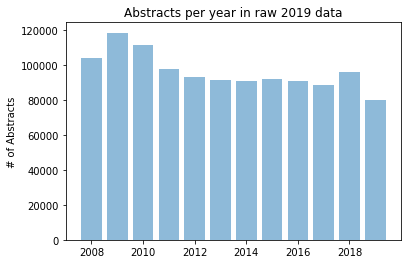

In [456]:
plt.bar(rawyear.index, rawyear, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('# of Abstracts')
plt.title('Abstracts per year in raw 2019 data')

plt.show()

In [457]:
year = rnd.FY.value_counts().sort_index()
year

2008.0     99431
2009.0    113722
2010.0    105804
2011.0     92836
2012.0     86290
2013.0     86659
2014.0     86461
2015.0     88403
2016.0     89412
2017.0     87851
2018.0     95718
2019.0     79846
Name: FY, dtype: int64

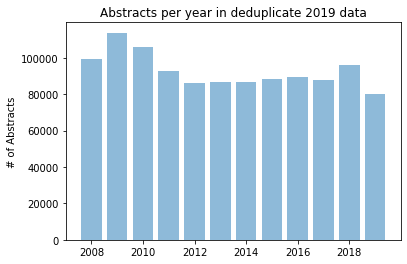

In [458]:
plt.bar(year.index, year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('# of Abstracts')
plt.title('Abstracts per year in deduplicate 2019 data')

plt.show()

In [459]:
oldyear = old.FY.value_counts().sort_index()
oldyear

2008    94846
2009    53413
2010    46349
2011    42761
2012    64056
2013    53345
2014    43325
2015    42252
2016    39681
2017    34619
2018    35441
Name: FY, dtype: int64

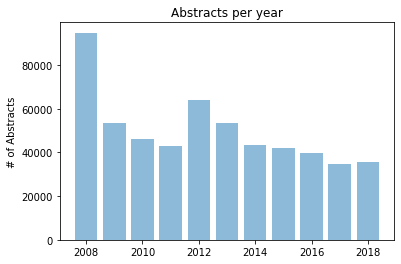

In [460]:
plt.bar(oldyear.index, oldyear, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('# of Abstracts')
plt.title('Abstracts per year')

plt.show()

### NAs per year

In [461]:
df = rnd

In [462]:
nans = df.isnull()
nans = nans.drop('FY', axis=1)
nans['FY'] = df['FY']

In [463]:
nans = nans.groupby('FY').sum()
nans

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,...,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,org_count
FY,,,,,,,,,,,,,,,,,,,,,
2008.0,0.0,0.0,3536.0,0.0,0.0,0.0,99431.0,0.0,0.0,11125.0,...,257.0,859.0,3826.0,255.0,99431.0,99431.0,15101.0,22604.0,99415.0,0.0
2009.0,0.0,0.0,0.0,0.0,0.0,0.0,113722.0,0.0,0.0,11285.0,...,144.0,704.0,3825.0,144.0,113722.0,113722.0,15155.0,21757.0,113713.0,0.0
2010.0,0.0,0.0,0.0,0.0,0.0,0.0,105804.0,0.0,0.0,10867.0,...,494.0,997.0,4245.0,488.0,105804.0,105804.0,15245.0,20115.0,105785.0,0.0
2011.0,0.0,0.0,0.0,0.0,0.0,0.0,92836.0,0.0,0.0,10090.0,...,244.0,739.0,3819.0,246.0,92836.0,92836.0,15074.0,19364.0,92809.0,0.0
2012.0,0.0,0.0,0.0,0.0,0.0,0.0,16773.0,0.0,0.0,3712.0,...,209.0,711.0,3853.0,208.0,21798.0,21801.0,15520.0,13540.0,75956.0,0.0
2013.0,0.0,0.0,0.0,0.0,0.0,0.0,86659.0,0.0,0.0,11304.0,...,203.0,686.0,3499.0,202.0,86659.0,86659.0,16309.0,14909.0,86647.0,0.0
2014.0,0.0,0.0,0.0,0.0,0.0,0.0,16931.0,0.0,0.0,3299.0,...,219.0,731.0,3536.0,216.0,21796.0,21797.0,15813.0,86347.0,86424.0,0.0
2015.0,0.0,0.0,0.0,0.0,0.0,0.0,18138.0,0.0,0.0,3449.0,...,286.0,923.0,6234.0,218.0,23253.0,23253.0,15928.0,15414.0,77483.0,0.0
2016.0,0.0,0.0,0.0,0.0,0.0,0.0,17944.0,0.0,0.0,3302.0,...,174.0,772.0,3422.0,101.0,23083.0,23084.0,15862.0,14746.0,78475.0,0.0


In [464]:
totalnan = nans.sum(axis = 1)
totalnan

FY
2008.0    555438.0
2009.0    619311.0
2010.0    578620.0
2011.0    510782.0
2012.0    260823.0
2013.0    475287.0
2014.0    337434.0
2015.0    266381.0
2016.0    261251.0
2017.0    244272.0
2018.0    261623.0
2019.0    202448.0
dtype: float64

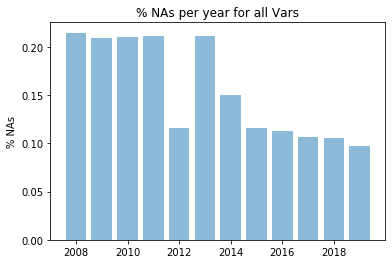

In [465]:
plt.bar(totalnan.index, totalnan/(year*len(df.columns)), align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('% NAs per year for all Vars')

plt.show()

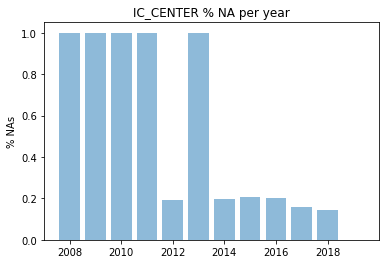

In [466]:
plt.bar(nans.index, nans.IC_CENTER/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('IC_CENTER % NA per year')

plt.show()

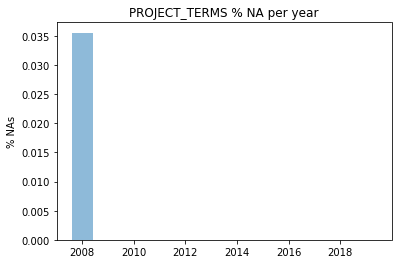

In [467]:
plt.bar(nans.index, nans.PROJECT_TERMS/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('PROJECT_TERMS % NA per year')

plt.show()

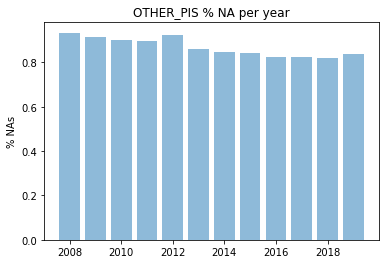

In [468]:
plt.bar(nans.index, nans.OTHER_PIS/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('OTHER_PIS % NA per year')

plt.show()

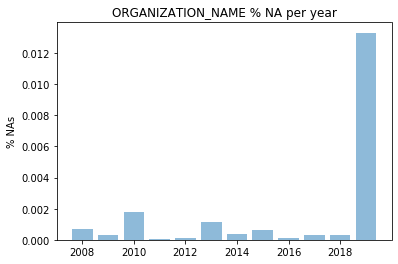

In [469]:
plt.bar(nans.index, nans.ORGANIZATION_NAME/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('ORGANIZATION_NAME % NA per year')

plt.show()

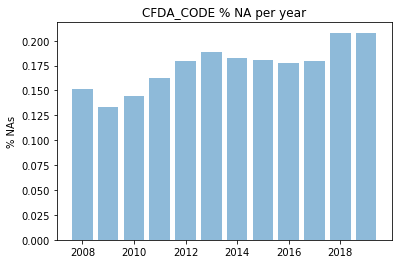

In [470]:
plt.bar(nans.index, nans.CFDA_CODE/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('CFDA_CODE % NA per year')

plt.show()

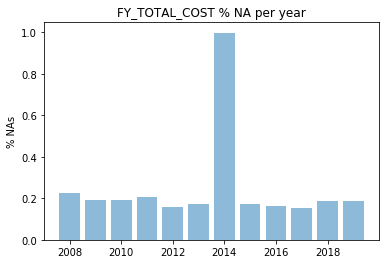

In [471]:
plt.bar(nans.index, nans.FY_TOTAL_COST/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('FY_TOTAL_COST % NA per year')

plt.show()

In [472]:
len(df[df.FY == 2014])

86461

In [473]:
df[df.FY == 2014]['FY_TOTAL_COST'].isnull().sum()

86347

In [474]:
df[df.FY == 2014]['FY_TOTAL_COST_SUB_PROJECTS'].isnull().sum()

86424

In [475]:
same = df.DEPARTMENT == df.AGENCY

In [476]:
same.sum()

166157

In [477]:
len(df) - same.sum()

946276

While there are no NAN values in DEPARTMENT or AGENCY, there are mismatched between them on ~5/6 of the rows